# 3行で

・井出・杉山の異常検知と変化検知で説明されてるアルゴリズムを実問題（に近いなにか）に適用したい  
・まずはホテリングのT2法をkaggleのCredit Card Fraud Detectionをやってみたぞ  
https://www.kaggle.com/mlg-ulb/creditcardfraud

# 理論の説明

詳細は本をご購入ください。

アルゴリズムをざっと説明すると  
1. （パラメータ決定）異常度の分布であるカイ2乗分布から異常と判定する閾値を決定する  
2. （訓練）（正常標本が圧倒的に多いデータから）標本平均、標本共分散行列を計算する
3. （推論1）2で求めた標本共分散行列で定義される標本平均と推論対象のデータのマハラノビス距離を計算し、その推論対象の異常度とする
4. （推論2）計算された異常度が閾値を超えたものを異常と判定する

  

# データのロード

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.stats

df = pd.read_csv("creditcard.csv")

あとで使うモジュールもここでimportしておく

# データ概観

In [17]:
df.head(3)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

V1からV28はカード会社の持っているデータをPCAしたもののようです。  
生データは機密だからみせられないよ！とのこと。  
PCAされているので共分散行列は対角化されていると期待できる。  

In [16]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.656562e-16 -3.444850e-16  2.578648e-16  4.471968e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.687098e-15 -3.666453e-16 -1.220404e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

stdをみると、V1からV28まで降順で並んでいるのがわかる  
V1からV28はPCAしたときの共分散行列の固有値の大きい順に並んでいるようだ。  
また、meanを見るとほとんど0に近い値が並んでいる  
PCAしているので平均が0になるようにシフトされている

In [23]:
df.cov()

Time            V1            V2            V3            V4  \
Time    2.255124e+09  1.091960e+04 -8.307031e+02 -3.021425e+04 -7.077378e+03   
V1      1.091960e+04  3.836489e+00 -3.668399e-16 -1.591003e-15 -7.327817e-16   
V2     -8.307031e+02 -3.668399e-16  2.726820e+00  1.722431e-16 -5.294779e-16   
V3     -3.021425e+04 -1.591003e-15  1.722431e-16  2.299029e+00 -4.621923e-16   
V4     -7.077378e+03 -7.327817e-16 -5.294779e-16 -4.621923e-16  2.004684e+00   
V5      1.134407e+04  8.378639e-16  1.705466e-16 -1.297100e-15 -3.576902e-15   
V6     -3.986868e+03  3.333094e-16  8.324751e-16  2.939634e-15 -7.963000e-16   
V7      4.976739e+03  9.924436e-17 -2.573168e-16  5.082718e-16 -1.949710e-16   
V8     -2.095683e+03 -5.408793e-17  4.291109e-18 -5.758069e-17  1.121726e-15   
V9     -4.518322e+02  8.332734e-17 -1.894075e-16  2.412002e-16  9.433454e-16   
V10     1.583108e+03  1.150616e-16 -2.581651e-16  3.983746e-16 -1.549290e-16   
V11    -1.200595e+04  6.134539e-16  5.897780e-16  1.855406e-16 -3.985991e-16   
V12     5.900343e+03  2.879035e-16 -5.113904e-16  2.192457e-16 -2.237614e-16   
V13    -3.114775e+03 -1.150366e-16 -2.421233e-17 -1.552408e-17  6.985526e-18   
V14    -4.495601e+03  6.929642e-16 -5.958903e-16  9.764268e-16 -1.340223e-16   
V15    -7.974101e+03 -1.809002e-16  1.848171e-16 -9.166008e-17  2.706080e-16   
V16     4.952977e+02  5.285673e-16  3.155961e-17  7.528650e-16 -9.837117e-17   
V17    -2.956329e+03 -9.979323e-20 -8.274355e-16  2.238861e-16 -4.450404e-16   
V18     3.599748e+03  2.506182e-16  3.313010e-16  3.611642e-16 -1.999607e-17   
V19     1.120106e+03  2.628616e-16  1.322260e-17  4.161378e-16 -3.186273e-16   
V20    -1.862195e+03  1.167581e-16  8.602176e-17  1.501888e-17 -2.057175e-16   
V21     1.560435e+03 -1.691534e-16  8.721928e-17 -1.889959e-16 -5.786136e-17   
V22     4.964595e+03  1.559269e-16  2.080689e-16 -2.348384e-16  2.599239e-16   
V23     1.516599e+03  2.421982e-16  9.431707e-17 -7.394678e-17  1.700352e-16   
V24    -4.654076e+02 -5.106918e-17 -1.081634e-16  3.089224e-17  1.347708e-16   
V25    -5.769855e+03 -3.270723e-16  1.314776e-16  5.925223e-17  4.773297e-16   
V26    -9.482254e+02 -1.284838e-16  2.006343e-16 -1.715297e-16 -2.689739e-16   
V27    -9.841860e+01  9.270791e-17 -3.456338e-16  3.409186e-16 -6.540199e-17   
V28    -1.475443e+02  2.291751e-16 -1.968671e-16  3.703327e-16 -4.341005e-18   
Amount -1.258610e+05 -1.115566e+02 -2.194854e+02 -7.997555e+01  3.496456e+01   
Class  -2.430072e+01 -8.243501e-03  6.260047e-03 -1.214993e-02  7.846318e-03   

                  V5            V6            V7            V8            V9  \
Time    1.134407e+04 -3.986868e+03  4.976739e+03 -2.095683e+03 -4.518322e+02   
V1      8.378639e-16  3.333094e-16  9.924436e-17 -5.408793e-17  8.332734e-17   
V2      1.705466e-16  8.324751e-16 -2.573168e-16  4.291109e-18 -1.894075e-16   
V3     -1.297100e-15  2.939634e-15  5.082718e-16 -5.758069e-17  2.412002e-16   
V4     -3.576902e-15 -7.963000e-16 -1.949710e-16  1.121726e-15  9.433454e-16   
V5      1.905081e+00  1.156005e-15 -1.397105e-18  8.149115e-16  8.041837e-16   
V6      1.156005e-15  1.774946e+00 -5.304010e-17 -5.904266e-16 -1.975345e-16   
V7     -1.397105e-18 -5.304010e-17  1.530401e+00 -5.867842e-17  3.567608e-17   
V8      8.149115e-16 -5.904266e-16 -5.867842e-17  1.426479e+00  5.726634e-16   
V9      8.041837e-16 -1.975345e-16  3.567608e-17  5.726634e-16  1.206992e+00   
V10     1.886092e-16  1.885094e-16  4.369446e-16  5.214196e-17 -3.406442e-16   
V11     1.059954e-15  1.252530e-15 -4.654107e-16  1.648335e-16  3.325110e-16   
V12     4.985046e-16  3.857382e-16  8.852408e-16  6.361818e-17 -1.452939e-15   
V13    -3.766882e-16 -2.110751e-16 -9.082431e-17 -3.522666e-16  1.031550e-15   
V14     3.198373e-16  4.424582e-16  3.789648e-17 -2.466140e-16  1.055974e-15   
V15     1.742967e-16 -1.507127e-16 -7.203823e-17  1.270056e-16 -9.079687e-16   
V16     7.070849e-16 -1.168329e-16  4.634148e-16  1.289328e-16 -4.782091e-16   
V17     5.43810

共分散行列の非対角成分は確かにほぼ0になっており、対角化されている。

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

欠損はない。  
なので今回の解析では補完しなくてよい。  
このデータを作るときに誰かが前処理してPCAしてるはずだが、その際補完したのかもしれない。

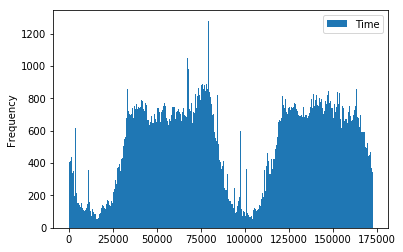

<Figure size 432x288 with 0 Axes>

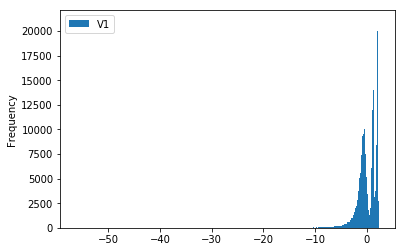

<Figure size 432x288 with 0 Axes>

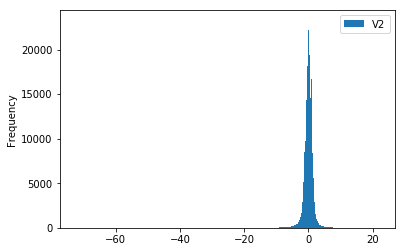

<Figure size 432x288 with 0 Axes>

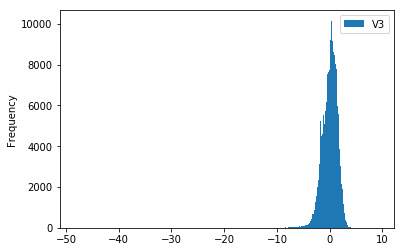

<Figure size 432x288 with 0 Axes>

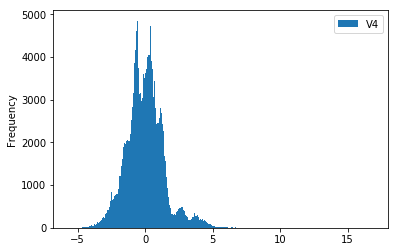

<Figure size 432x288 with 0 Axes>

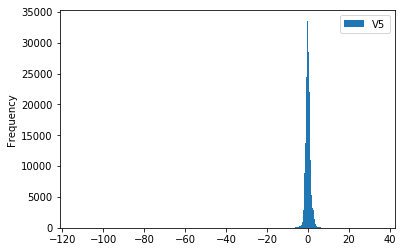

<Figure size 432x288 with 0 Axes>

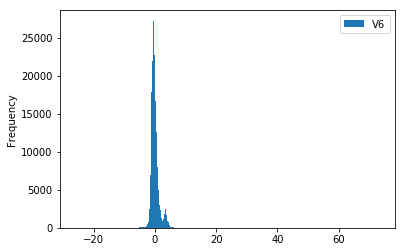

<Figure size 432x288 with 0 Axes>

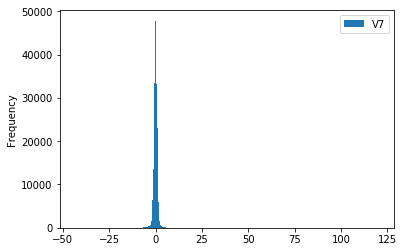

<Figure size 432x288 with 0 Axes>

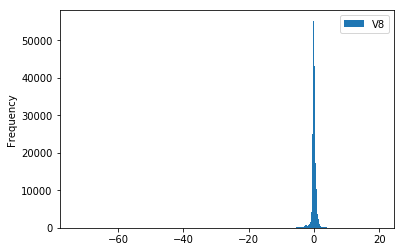

<Figure size 432x288 with 0 Axes>

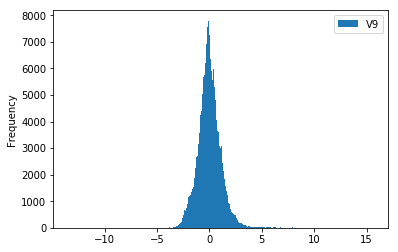

<Figure size 432x288 with 0 Axes>

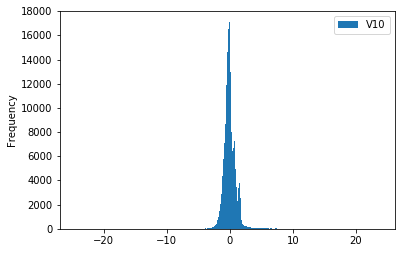

<Figure size 432x288 with 0 Axes>

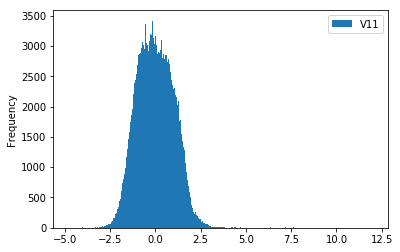

<Figure size 432x288 with 0 Axes>

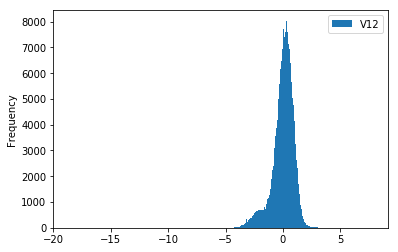

<Figure size 432x288 with 0 Axes>

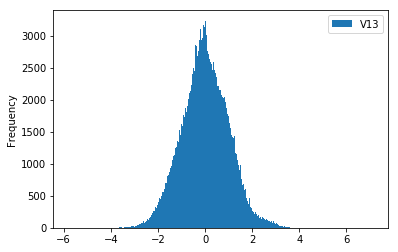

<Figure size 432x288 with 0 Axes>

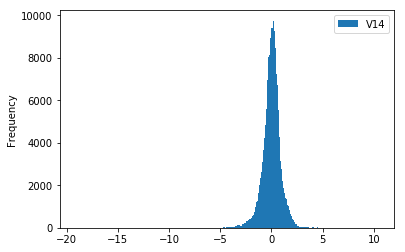

<Figure size 432x288 with 0 Axes>

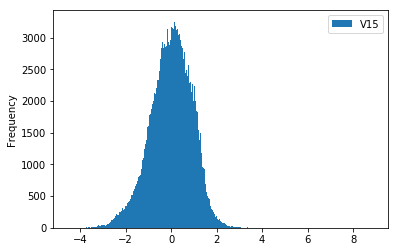

<Figure size 432x288 with 0 Axes>

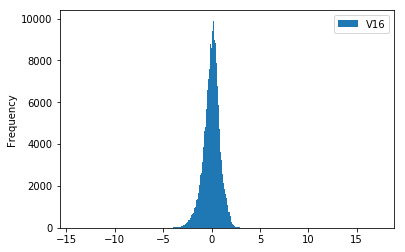

<Figure size 432x288 with 0 Axes>

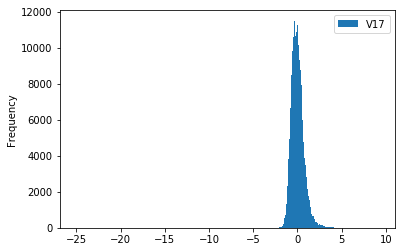

<Figure size 432x288 with 0 Axes>

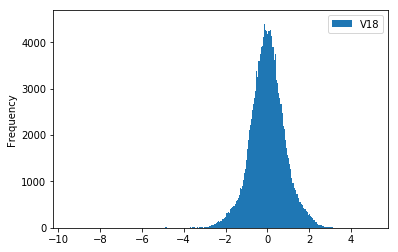

<Figure size 432x288 with 0 Axes>

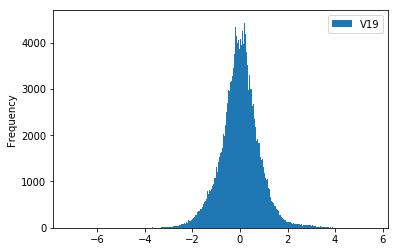

<Figure size 432x288 with 0 Axes>

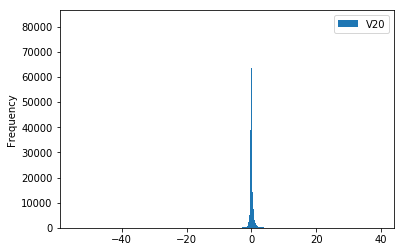

<Figure size 432x288 with 0 Axes>

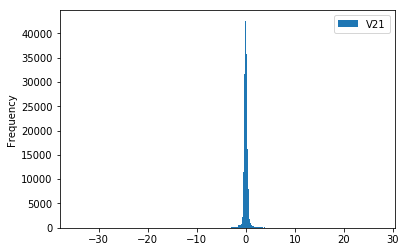

<Figure size 432x288 with 0 Axes>

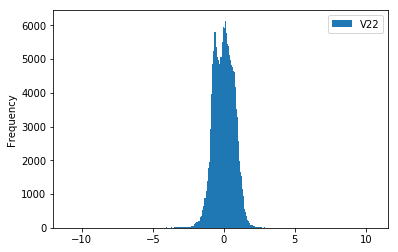

<Figure size 432x288 with 0 Axes>

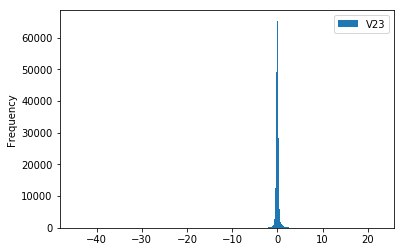

<Figure size 432x288 with 0 Axes>

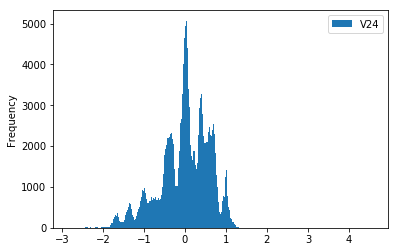

<Figure size 432x288 with 0 Axes>

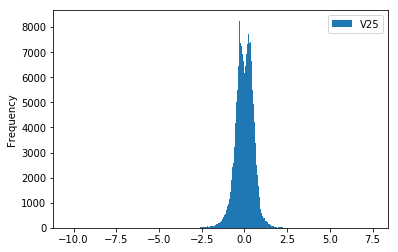

<Figure size 432x288 with 0 Axes>

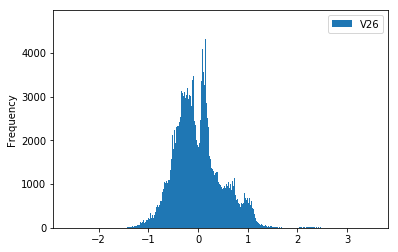

<Figure size 432x288 with 0 Axes>

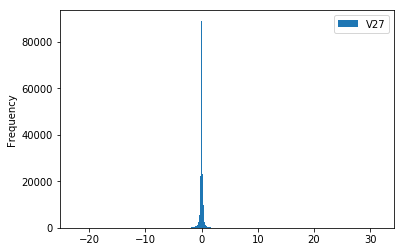

<Figure size 432x288 with 0 Axes>

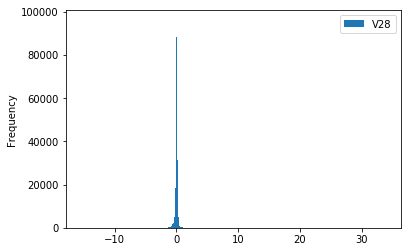

<Figure size 432x288 with 0 Axes>

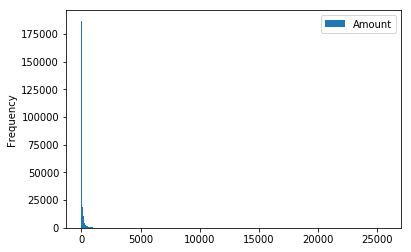

<Figure size 432x288 with 0 Axes>

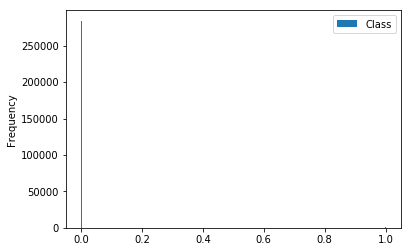

<Figure size 432x288 with 0 Axes>

In [33]:
for label in df.columns:
    df.plot(kind='hist', y=label , bins=int(np.sqrt(len(df))))
    plt.show()
    plt.clf()

標本のヒストグラムを片っ端から作ってみた。  
見てみると多峰的だったり片方にテールを引いていたりするものもある。  
現実は綺麗な正規分布になるとは限らないのである  
だが、今回はあえて無視して正規分布を仮定してモデリングする。

次に異常と判定されるべきクラスを概観する

In [10]:
group_by_class = df.groupby("Class")
df_fraud = group_by_class.get_group(1)
df_fraud.describe()

Time          V1          V2          V3          V4  \
count     492.000000  492.000000  492.000000  492.000000  492.000000   
mean    80746.806911   -4.771948    3.623778   -7.033281    4.542029   
std     47835.365138    6.783687    4.291216    7.110937    2.873318   
min       406.000000  -30.552380   -8.402154  -31.103685   -1.313275   
25%     41241.500000   -6.036063    1.188226   -8.643489    2.373050   
50%     75568.500000   -2.342497    2.717869   -5.075257    4.177147   
75%    128483.000000   -0.419200    4.971257   -2.276185    6.348729   
max    170348.000000    2.132386   22.057729    2.250210   12.114672   

               V5          V6          V7          V8          V9  ...  \
count  492.000000  492.000000  492.000000  492.000000  492.000000  ...   
mean    -3.151225   -1.397737   -5.568731    0.570636   -2.581123  ...   
std      5.372468    1.858124    7.206773    6.797831    2.500896  ...   
min    -22.105532   -6.406267  -43.557242  -41.044261  -13.434066  ...   
25%     -4.792835   -2.501511   -7.965295   -0.195336   -3.872383  ...   
50%     -1.522962   -1.424616   -3.034402    0.621508   -2.208768  ...   
75%      0.214562   -0.413216   -0.945954    1.764879   -0.787850  ...   
max     11.095089    6.474115    5.802537   20.007208    3.353525  ...   

              V21         V22         V23         V24         V25         V26  \
count  492.000000  492.000000  492.000000  492.000000  492.000000  492.000000   
mean     0.713588    0.014049   -0.040308   -0.105130    0.041449    0.051648   
std      3.869304    1.494602    1.579642    0.515577    0.797205    0.471679   
min    -22.797604   -8.887017  -19.254328   -2.028024   -4.781606   -1.152671   
25%      0.041787   -0.533764   -0.342175   -0.436809   -0.314348   -0.259416   
50%      0.592146    0.048434   -0.073135   -0.060795    0.088371    0.004321   
75%      1.244611    0.617474    0.308378    0.285328    0.456515    0.396733   
max     27.202839    8.361985    5.466230    1.091435    2.208209    2.745261   

              V27         V28       Amount  Class  
count  492.000000  492.000000   492.000000  492.0  
mean     0.170575    0.075667   122.211321    1.0  
std      1.376766    0.547291   256.683288    0.0  
min     -7.263482   -1.869290     0.000000    1.0  
25%     -0.020025   -0.108868     1.000000    1.0  
50%      0.394926    0.146344     9.250000    1.0  
75%      0.826029    0.381152   105.890000    1.0  
max      3.052358    1.779364  2125.870000    1.0  

[8 rows x 31 columns]

countを見ると、異常クラスの標本サイズは492個あるようだ  
データ全体が284807個あるので、およそ0.2%が異常。  
データ全体と比べ、meanは0に近くない。  
ホテリングのT2法は標本平均からのズレをマハラノビス距離で評価するものだから  
異常クラスの標本平均が標本全体の標本平均と違うことはホテリングのT2法が「全然使えないわけじゃない」ことを予感させる。  
ただし、異常クラスのV1のminは標本全体のV1のminより大きい。
これはV1の最小値である-5.640751e+01の値を持つ標本は正常クラスに属していることを示している。  
V1以外の特徴量を考慮することでこの点は克服できるだろうか？

# 訓練

### 0.　データ分割  
データを訓練用、交差検証用の2つに分割する

In [12]:
df_use = df.drop(['Time','Amount'],axis=1)
df_train, df_test= train_test_split(df_use, test_size=0.1)
target_train = df_train['Class']
target_test = df_test['Class']
df_train = df_train.drop('Class',axis=1)
df_test = df_test.drop('Class',axis=1)

### 1. 異常度の分布であるカイ2乗分布から異常と判定する閾値を決定する   
下記の式にしたがって異常度の閾値を決定する。  
$$
1-\alpha = \int ^{a_{\mathrm{th}}} _0 dx \chi ^2 (x|M,1)
$$
$\alpha$は誤報率。カイ2乗分布に従う確率変数に対して、どれぐらいの確率で起きそうなことが起きてしまったら異常であるとみなすか決めている。  
$a_{\mathrm{th}}$が異常度の閾値。
$M$は自由度。
理屈はこうだが、計算しやすいように少し変形する。  
カイ二乗分布の累積分布関数は以下のように定義される。  
$$
X ^2 (x|k,s) =  \int ^{x} _0 dt \chi ^2 (t|k,s)
$$
scipy.stats.chi2で定義されている便利な関数にSurvival functionとその逆関数がある。  
Survival functionは$1-X ^2 (x|k,s)$で定義される。  
Survival functionの逆関数を$isf(x|k,s)$とすれば、求めるべき$a_{\mathrm{th}}$は
$$
a_{\mathrm{th}} = isf(\alpha |M,1)
$$
となる。

In [13]:
def a_threshold(prob,degree_of_freedom):
    anomality = scipy.stats.chi2.isf(prob, degree_of_freedom)
    return anomality

def test_a_threshold():
    prob = 0.05
    a_th = a_threshold(prob,30)
    print(a_th)

テスト用のコードを実行すると異常度の閾値が表示されるので   
これを分布表と照らしあわせて正しい値が出ていることを確認できる。  
例えば上記の条件だと、異常度の閾値は43.77297182574217になるが  
これは　https://www.biwako.shiga-u.ac.jp/sensei/mnaka/ut/chi2disttab.html　を見ても  
正しい値が計算できている

### 2. 訓練用データの標本平均、標本共分散行列を計算し、異常度を算出できるようにする

`TsqDetector`というクラスを定義する。  
このクラスはホテリングのT2法を実行するために必要なパラメータをメンバ変数にもち  
与えられた`df`に対してホテリングのT2法を実行して異常度と判定結果を返すメソッドを持つ。  

実装が正しく行われていることを確認するためのテストのための関数をつけておいた。  
「手計算」でホテリングのT2法が実行できる小さなデータセットに対して正しく異常度を計算できるか確認できる。  

In [20]:
class TsqDetector(object):
    def __init__(self,mean,cov,prob,dof):
        self.mean = mean
        self.cov = cov
        self.dof = dof
        self.prob = prob
        self.threshold = a_threshold(prob,dof)
        
        
    def set_mean(self,df_train):
        self.mean = df_train.mean()
        
    def set_cov(self,df_train):
        self.cov = df_train.cov()
        
    def set_threshold(self,prob):
        self.threshold = a_threshold(prob,self.dof)
    
    def calc_anomality(self,df_test):
        #calc anomality for each test data
        result = []
        metric = self.cov.values
        metric = np.linalg.inv(metric)
        iter = 0
        for index, row in df_test.iterrows():
            dist = row - self.mean
            dist = np.dot(metric, dist.values.T)
            dist = np.dot(row-self.mean,dist)
            iter += 1
            result.append(dist)
            if iter % 1000 == 999:
                #print(iter+1," th iteration")
                pass
        #return list of anomality
        return result
        
    def examine(self,df_test):
        #calc anomality
        list_anomality = self.calc_anomality(df_test)
        
        #compare a_th
        list_prediction = [0 if anomality < self.threshold else 1 for anomality in list_anomality]

        #return result list
        return list_anomality, list_prediction 
    
    def re_examine(self,list_anomality,prob):
        list_prediction = [0 if anomality < a_threshold(prob,self.dof) else 1 for anomality in list_anomality]
        return list_prediction
        

#debug code
def test_TsqDetector():
    df_check=pd.DataFrame({'V1':[101,102,130,99,98],'V2':[95,105,70,103,101],'Class':[0,0,1,0,0]})
    group_by_class = df_check.groupby("Class")
    df_neg = group_by_class.get_group(0)
    Detector = TsqDetector(mean=df_neg.drop('Class',axis=1).mean(),cov=df_neg.drop('Class',axis=1).cov(),prob=0.005)
    df_check['anomality'], df_check['prediction'] = Detector.examine(df_check)
    no0_anomality = (101-100)*((10/3)**(-1))*(101-100) + (95-101)*(18.6666667**(-1))*(95-101)
    print(no0_anomality)
    print(df_check)

### 3. 交差検証用データで推論の妥当性を検証する

試しに誤報率を0.2%に設定して分類器を作ってみる。
これは標本全体に占める異常クラスの標本数の割合と等しい。

In [89]:
Detector = TsqDetector(mean=df_train.mean(),cov=df_train.cov(),prob=0.002,dof=len(df_train.columns))
anomality, prediction = Detector.examine(df_test)

1000  th iteration
2000  th iteration
3000  th iteration
4000  th iteration
5000  th iteration
6000  th iteration
7000  th iteration


In [17]:
confusion_matrix(target_test,prediction)

confusion_matrixのindexは(grand truth, prediction)  
非対角成分が予測に失敗している標本の数になる  
つまり、  
左上がTN  
右上がFP  
左下がFN  
右下がTP  

### 4. ROC曲線の作成

ROC曲線とは、以下の式で定義されるxy平面上の点の集合がなす曲線のことである  
$$
(x,y) = (1-r_0(\tau), r_1(\tau))
$$
なお、$r_0(\tau)$、$r_1(\tau)$はそれぞれ閾値$\tau$の時の正常標本精度、異常標本精度で、以下の式で定義される  
$$
r_0(\tau) = \frac{TN(\tau)}{TN(\tau)+FP(\tau)} \\
r_1(\tau) = \frac{TP(\tau)}{TP(\tau)+FN(\tau)} 
$$

In [22]:
Detector = TsqDetector(mean=df_train.mean(),cov=df_train.cov(),prob=0.002,dof=len(df_train.columns))
list_anomality = Detector.calc_anomality(df_test)

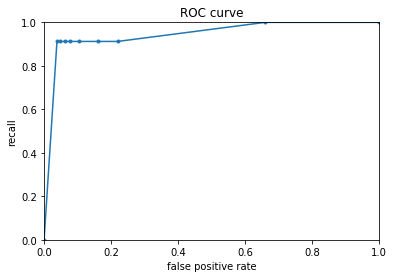

In [27]:
def make_ROC_curve(tau_list, list_anomality, Detector):
    x = np.array([1])
    y = np.array([1])
    CMs = np.array([])
    
    for tau in tau_list:
        prediction = Detector.re_examine(list_anomality, tau)
        CM = confusion_matrix(target_test,prediction)
        r0 = CM[0][0]/(CM[0][0]+CM[0][1])
        r1 = CM[1][1]/(CM[1][0]+CM[1][1])
        x=np.append(x,1-r0)
        y=np.append(y,r1)
        CMs=np.append(CMs,CM)
        
    x=np.append(x,0)
    y=np.append(y,0)    
    
    plt.plot(x,y,marker='.')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title("ROC curve")
    plt.xlabel("false positive rate")
    plt.ylabel("recall")
    plt.show()
    
    return x,y,CMs

tau_list = [0.99,0.5,0.3,0.1,0.03,0.01,0.001,0.0001]
x,y,CMs=make_ROC_curve(tau_list, list_anomality, Detector)

ROC曲線が得られたので、AUCを計算してみる。  
AUCはROC曲線の下部面積で定義される。  
ROC曲線は区分的に直線だと近似して台形公式で面積を求める。  

In [28]:
def AUC_calc(x,y):
    #make sure input x, y are sorted
    curve=np.vstack([x,y])
    curve=curve[:,np.argsort(curve[0])]
    
    area = 0
    for i in range(len(x)-1):
        area += 1/2*(curve[0][i+1]-curve[0][i])*(curve[1][i]+curve[1][i+1])
    return area

print("AUC=",AUC_calc(x,y))

AUC= 0.943841317690511


top kernelのAUCが0.95なのでかなり良く出来ているのでしょう。  
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now  
でもなーFPがTPの10倍出てるわけで、この分類器使うと鬱陶しいかもしれない。
詐欺検出なんだから、疑わしきは調査というスタンスならこういう運用もあり。  
実用上は調査にかかるコストと検出漏れの際の損失を天秤にかけてバランスとるんでしょう。  
つまり、1回あたりの調査コストを$f$、1回あたりの検出漏れ損失額を$g$として
$$
argmin_{\tau}\left[ \frac{FP(\tau)+TP(\tau)}{TP(\tau)+TN(\tau)+FP(\tau)+FN(\tau)}f+\frac{FN(\tau)}{TP(\tau)+TN(\tau)+FP(\tau)+FN(\tau)}g \right]
$$
を満たす$\tau$を取ってくればいいでしょう。

# 異常度のヒストグラム

交差検証用のデータセットについて異常度が計算できたので、異常度の分布を調べてみましょう。  

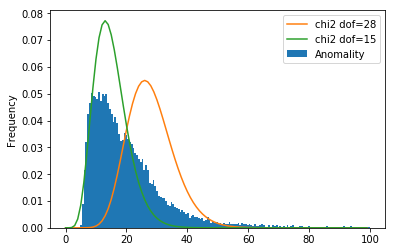

In [74]:
hist_max=100

df_result = pd.DataFrame({'Grand truth':target_test,"Anomality":list_anomality})
df_result.plot(kind='hist', y="Anomality" , bins=int(np.sqrt(len(df_result))), 
               range=(0,hist_max), density=True)

chi2_x = range(0,hist_max,1)
chi2_y = [scipy.stats.chi2.pdf(x=x,df=28) for x in chi2_x] 
plt.plot(chi2_x,chi2_y,label="chi2 dof=28")

chi2_x = range(0,hist_max,1)
chi2_y = [scipy.stats.chi2.pdf(x=x,df=15) for x in chi2_x] 
plt.plot(chi2_x,chi2_y,label="chi2 dof=15")

plt.legend()
plt.show()

交差検証用データの異常度の分布はこんな感じ。
カイ二乗分布に従う想定をしたので、カイ二乗分布を同時にプロットした。  
自由度28のカイ二乗分布から想定されるヒストグラムよりかなりピークが左にずれてしまっている。  
書籍によれば、データの有効次元が理論的に想定される値よりかなり小さくなるのはよくあることらしい。  
実際、このデータに対して例えば自由度15のカイ二乗分布をあてはめてみると、多少マシになる（それでもぴったりは合わないが・・・）  
最適なパラメータの計算方法は書籍7.4章を参照のこと（そのうち実装するかも）

次に異常クラスの分布を見る。

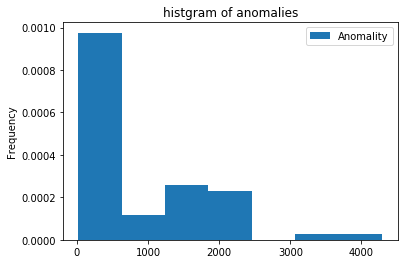

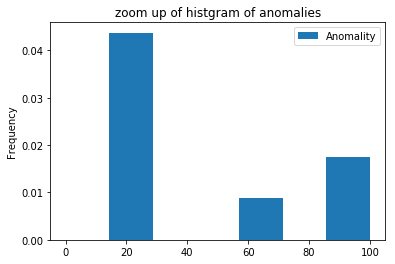

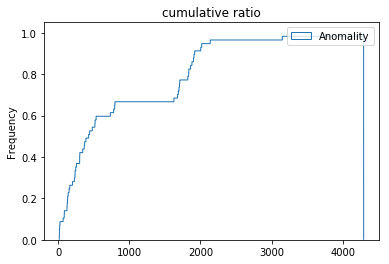

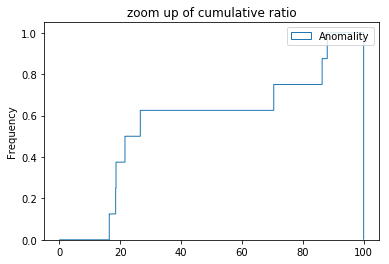

In [95]:
df_result_groupby = df_result.groupby("Grand truth")
df_result_fraud = df_result_groupby.get_group(1)
df_result_fraud.plot(kind='hist', y="Anomality" , bins=int(np.sqrt(len(df_result_fraud))),
                     density=True, title="histgram of anomalies")
                     
df_result_fraud.plot(kind='hist', y="Anomality" , bins=int(np.sqrt(len(df_result_fraud))),
                     density=True, title="zoom up of histgram of anomalies", range=(0,100))

df_result_fraud.plot(kind='hist', y="Anomality" , bins=5000, 
               cumulative=True,histtype='step',density=True, title="cumulative ratio")

df_result_fraud.plot(kind='hist', y="Anomality" , bins=5000, 
               cumulative=True,histtype='step',density=True,range=(0,100),title="zoom up of cumulative ratio")

この累積分布に対して1つ異常度の閾値を決めると、その点より右側は検出できる異常、左側は検出できない異常になります。
大きな異常度のところにある程度集まっているのは想定通りですね。  
  
  
ROC曲線の平坦な部分は累積分布の20あたりから70あたりの平坦な部分に閾値が来た時に対応していますね。  
`a_threshold(10e-4,29)`は58ぐらいなので、精度を落とさずにもう少し閾値を上げられるように思いますが  
安直に実行するのはこのデータセットだけに過学習する行為です。  
もし試すなら、検証用データを何度も取り替えてこの平坦な領域が出てくるか確認すべきでしょう。  

閾値を20以下にするとすべての異常を拾えますが、FPの割合が増えてしまいます。  
これがこのモデルの実力です。  
もしFPを増やさずに異常を拾う割合を増やしたければ、モデル自体を変更する必要があるでしょう。

In [99]:
a_threshold(10e-4,29)

58.30117348979492

# 考察

・`df_train`からモデルを作る際、正常クラスに属するデータが圧倒的に多いことが必要だった。
モデルを作る際は正常クラスを表すモデルを作ればいいので、正常クラスのみを使ってモデルを作ると予測精度が上がると思われる。  
  
・こんなシンプルなモデルでもそれなりにいい成績が出る。PCAが偉大なんだと思う。　　  

・変数間の相関を無視して、各変数は統計的に独立だとすると精度がわるくなるだろうか？  
試しに計算してみる。

`TsqDetector`を継承して`SimpleTsqDetector`クラスを定義する。  
ほとんど親クラスと同じだが、異常度の計算の実装が異なっている。  
マハラノビス距離の計算の前に共分散行列の非対角項を落としている。  
（ここ、多分`df.var()`で最初から分散のベクトル持ってきた方が計算速いと思う）  
`ROC_curve_simple`も`SimpleTsqDetector`を呼び出すように別の関数を定義　　
`ROC_curve_simple`の柔軟性、低いなあ・・・。

追記：曲線のデータ作成機能と異常度の計算機能を分離できることに気づいたので、同じ`make_ROC_curve`を使えるようになりました

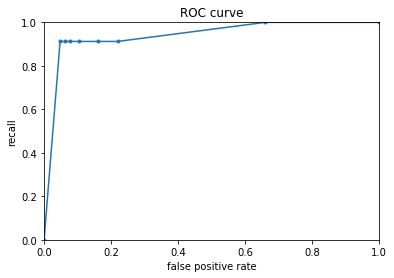

AUC= 0.9395565768488205


In [26]:
a=np.array([[1,2],[3,4]])
np.diag(np.diag(a))

class SimpleTsqDetector(TsqDetector):
    def __init__(self,mean,cov,prob,dof):
        super().__init__(mean,cov,prob,dof)
    
    def calc_anomality(self,df_test):
        #calc anomality for each test data
        result = []
        metric = self.cov.values
        metric = np.diag(np.diag(metric))
        metric = np.linalg.inv(metric)
        iter = 0
        for index, row in df_test.iterrows():
            dist = row - self.mean
            dist = np.dot(metric, dist.values)
            dist = np.dot(row-self.mean,dist)
            iter += 1
            result.append(dist)
            if iter % 1000 == 999:
                #print(iter+1," th iteration")
                pass
        #return list of anomality
        return result

tau_list = [0.99,0.5,0.3,0.1,0.03,0.01,0.001]
Detector = SimpleTsqDetector(mean=df_train.mean(),cov=df_train.cov(),
                                     prob=tau_list[0],dof=len(df_train.columns))
list_anomality = Detector.calc_anomality(df_test)
x,y,CMs=make_ROC_curve(tau_list,list_anomality, Detector)
print("AUC=",AUC_calc(x,y))

AUCはほとんど変わらず。  
PCAは偉大である。  
この手の異常検知タスクはまずPCAをしてホテリングのT2法できないか考えてみようと思えました。

# 参考文献

異常検知と変化検知（井手 剛、杉山 将　 講談社）  
https://www.amazon.co.jp/%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%81%A8%E5%A4%89%E5%8C%96%E6%A4%9C%E7%9F%A5-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E4%BA%95%E6%89%8B-%E5%89%9B/dp/4061529080